In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Eventually, for Anaconda warnings.
# Can be commented out.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load basic libraries
import seaborn; seaborn.set()
from itertools import chain
import nltk, pickle
import numpy as np
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV #TODO: update to model_selection
import sklearn_crfsuite
from sklearn_crfsuite import scorers, metrics

In [15]:
import pickle
data = pickle.load(open("data/test_data.p", "rb"))
print(len(data))

1291


In [16]:
# Generic Tagged BE Tag consolidation
correspondances = {
    'b-primary-full': 'b-primary', 
     'e-primary-full': 'e-primary', 
     'b-meta-annotation': 'b-meta-annotation', 
     'b-meta-annotation': 'b-meta-annotation', 
     'i-meta-annotation': 'i-meta-annotation', 
     'i-secondary-full': 'i-secondary', 
     'i-primary-full': 'i-primary', 
     'e-meta-annotation': 'e-meta-annotation', 
     'e-primary-partial': 'e-primary', 
     'b-meta-annotation': 'b-meta-annotation', 
     'e-secondary-full': 'e-secondary', 
     'o': 'o', 
     'b-secondary-full': 'b-secondary', 
     'i-primary-partial': 'i-primary', 
     'i-meta-annotation': 'i-meta-annotation', 
     'i-secondary-partial': 'i-secondary', 
     'b-secondary-partial': 'b-secondary', 
     'e-secondary-partial': 'e-secondary', 
     'b-primary-partial': 'b-primary', 
     'e-meta-annotation': 'e-meta-annotation'
}
# define supporting functions
window = 2
from feature_extraction_words import word2features, generate_featuresLight
def text2features(text):
    return [word2features(text, i, window = window) for i in range(len(text))]
def text2featuresL(text):
    return [word2features(text, i, window = window, feature_function=generate_featuresLight) for i in range(len(text))]
# With extra Specifc Tags. Adding specific tags improves performances
def text2featuresEX(text, extra_labels):
    return [word2features(text, i, extra_labels, window = window) for i in range(len(text))]
def text2featuresLEX(text, extra_labels):
    return [word2features(text, i, extra_labels, window = window, feature_function=generate_featuresLight) for i in range(len(text))]

# create generic tags Y
def text2labelsG(text):
    return [correspondances[token[2][0]] for token in text]

# create beginend tags Y
def text2labelsBE(text):
    return [token[2][2] for token in text]

# create tagged-beginend tags Y
def text2labelsTBE(text):
    return [correspondances[token[2][3]] for token in text]

# create specific tags Y
def text2labelsS(text):
    return [correspondances[token[2][1]] for token in text]

In [17]:
# prepare data for CRF
annotated_data = list()
annotated_labels = list()
for doc in data:
    ar_data_ann = list()
    ar_labels_ann = list()
    for page in doc["pages"].values():
        if page["is_annotated"]:
            ar_data_ann.extend(page["offsets"])
            ar_labels_ann.extend(page["specific_tags"])
    if len(ar_data_ann) > 0:
        annotated_data.append(ar_data_ann)
        annotated_labels.append(ar_labels_ann)
print(len(annotated_data))
print(len(data))

287
1291


In [18]:
%%time
# Define train and test sets for experiments
from sklearn.cross_validation import train_test_split
d = [text2featuresEX(text, lab) for text, lab in zip(annotated_data, annotated_labels)]
l = [text2labelsTBE(text) for text in annotated_data]
# Clean tag space
labels_to_keep = sorted(list(set([x for y in l for x in y])))
# VALIDATION set
X_rest, X_valid, y_rest, y_valid = train_test_split(d, l, test_size=0.1)
# TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, test_size=0.25)

CPU times: user 2min 19s, sys: 9.91 s, total: 2min 29s
Wall time: 2min 29s


In [19]:
# Count labels
counts = {x:0 for x in labels_to_keep}
for c in counts.keys():
    counts[c] = len([x for y in l for x in y if x==c])
print(counts)

['i-primary', 'e-secondary', 'b-primary', 'o', 'i-meta-annotation', 'e-meta-annotation', 'b-meta-annotation', 'b-secondary', 'i-secondary', 'e-primary']
{'i-primary': 42946, 'i-meta-annotation': 115126, 'e-primary': 5395, 'b-meta-annotation': 5587, 'b-secondary': 16071, 'b-primary': 5327, 'e-secondary': 16234, 'e-meta-annotation': 5614, 'i-secondary': 151493, 'o': 78105}


In [9]:
# An example use of CRFs
crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))

                   precision    recall  f1-score   support

      b-secondary      0.787     0.860     0.822      3902
                o      0.938     0.975     0.956     20795
      i-secondary      0.784     0.876     0.828     34294
e-meta-annotation      0.713     0.712     0.712      1300
        b-primary      0.733     0.716     0.724      1160
i-meta-annotation      0.866     0.735     0.795     27895
        e-primary      0.812     0.784     0.798      1163
b-meta-annotation      0.720     0.685     0.702      1297
      e-secondary      0.807     0.854     0.830      3948
        i-primary      0.889     0.790     0.837      9290

      avg / total      0.845     0.842     0.841    105044



In [10]:
%%time
# Parameters search
crf = sklearn_crfsuite.CRF( 
    max_iterations=100,
    algorithm = 'lbfgs',
    all_possible_transitions=False
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05)
}

from sklearn.metrics import make_scorer
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-10, 
                        n_iter=5, 
                        scoring=scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-10)]: Done   2 out of  15 | elapsed: 11.6min remaining: 75.6min
[Parallel(n_jobs=-10)]: Done  15 out of  15 | elapsed: 18.3min finished


CPU times: user 17min 37s, sys: 1min 46s, total: 19min 24s
Wall time: 30min 39s


In [11]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

best params: {'c2': 0.024390658062424402, 'c1': 0.75837571972426676}
best CV score: 0.886989491646


In [ ]:
# Explore paramether space
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

                   precision    recall  f1-score   support

      b-secondary      0.810     0.874     0.841      3902
                o      0.943     0.977     0.960     20795
      i-secondary      0.811     0.873     0.841     34294
e-meta-annotation      0.713     0.732     0.722      1300
        b-primary      0.742     0.722     0.732      1160
i-meta-annotation      0.868     0.778     0.820     27895
        e-primary      0.832     0.817     0.824      1163
b-meta-annotation      0.768     0.719     0.742      1297
      e-secondary      0.821     0.862     0.841      3948
        i-primary      0.882     0.795     0.836      9290

      avg / total      0.856     0.855     0.854    105044

[[ 3411    74    75     4    51    49     1   188    33    16]
 [   67 20308   147     9    13    91    16    26    41    77]
 [  198   440 29951    39     9  2970     9    11   134   533]
 [    1     9     3   952     0    25     4     1   305     0]
 [  127    96     5     0   838     5

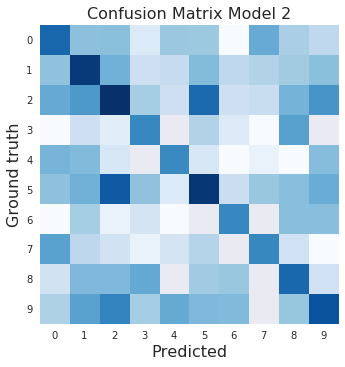

In [12]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels_to_keep, digits=3
))
# Confusion matrices
from sklearn.metrics import confusion_matrix
from support_functions import flatten_predictions

print(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep))
plt.imshow(np.log(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep)),
           cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.ylabel('Ground truth', fontsize=16)
plt.xlabel('Predicted', fontsize=16)
plt.xticks(np.arange(0, len(labels_to_keep), 1))
plt.yticks(np.arange(0, len(labels_to_keep), 1))
plt.title("Confusion Matrix Model 2", fontsize=16)
plt.savefig("plots/conf_M2_ALL.pdf")
#M = np.argsort(confusion_matrix(flatten_predictions(y_test), flatten_predictions(y_pred), labels=labels_to_keep), axis=1)
#print(M[:,-5:])

In [14]:
# K-fold validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels_to_keep)
# OR rs.best_params_
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2=0.024390658062424402, c1=0.75837571972426676,
    max_iterations=200, 
    all_possible_transitions=True
)
k = 5

cv = cross_val_score(crf, X_rest, y_rest, cv=k, scoring=scorer, n_jobs=-2)
print("%d-fold validation mean: "%k,cv.mean())

5-fold validation mean:  0.93050684343


In [ ]:
# Learning curves
from sklearn import cross_validation
from suppor_functions import plot_learning_curve

# Slices of data for learning curves
train_sizes=np.linspace(0.1, 1.0, 10)
title = "Learning Curves for Model 2"
message = "M2"
# Cross validation scheme with 80-20 splits and 5 iterations per train data size (to evaluate variance)
cv = cross_validation.ShuffleSplit(len(X_rest), n_iter=3,
                                   test_size=0.2, random_state=0)

estimator = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2=0.024390658062424402, c1=0.75837571972426676,
    max_iterations=200, 
    all_possible_transitions=True
)
plot_learning_curve(estimator, title, X_rest, y_rest, labels_to_keep, cv=cv, train_sizes=train_sizes, n_jobs=-2, message=message)

In [ ]:
%%time
# VALIDATION

crf = sklearn_crfsuite.CRF( 
    algorithm='lbfgs',
    c2=0.024390658062424402, c1=0.75837571972426676,
    max_iterations=500,
    all_possible_transitions=True
)
crf.fit(X_rest, y_rest)
y_pred = crf.predict(X_valid)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=labels_to_keep, digits=3
))

                   precision    recall  f1-score   support

        i-primary      0.888     0.789     0.836       892
      e-secondary      0.910     0.922     0.916      1286
        b-primary      0.766     0.736     0.751       129
                o      0.929     0.973     0.950      3385
i-meta-annotation      0.973     0.912     0.942      7339
e-meta-annotation      0.950     0.890     0.919       365
b-meta-annotation      0.930     0.878     0.903       362
      b-secondary      0.911     0.932     0.921      1271
      i-secondary      0.944     0.971     0.957     13804
        e-primary      0.780     0.767     0.773       129

      avg / total      0.943     0.943     0.943     28962

CPU times: user 1h 6min 54s, sys: 1min 22s, total: 1h 8min 17s
Wall time: 1h 8min 34s


In [ ]:
# Train final models for task 1
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c2=0.024390658062424402, c1=0.75837571972426676,
    max_iterations=500, 
    all_possible_transitions=True
)
crf.fit(d, l)

# save model
from sklearn.externals import joblib
joblib.dump(crf,'models/modelM2_ALL_L.pkl')

['models/modelM2_ALL_L.pkl']

In [20]:
# load model
from sklearn.externals import joblib
crf1 = joblib.load('models/modelM2_ALL_L.pkl')

In [21]:
def process_document(doc):
    for page in doc["pages"].values():
        if not page["is_annotated"]:
            data_to_tag = [text2featuresEX(page["offsets"],page["specific_tags"])]
            page_lab = crf.predict(data_to_tag)
            assert len(page_lab[0]) == len(page["offsets"])
            page.update({"BET_tags":page_lab[0]})
        else:
            page.update({"BET_tags":text2labelsTBE(page["offsets"])})
    return doc
            
from multiprocessing import Pool
threads = Pool(45)

In [22]:
# parse all
data2 = list()
for ar in threads.imap_unordered(process_document, data):
    data2.append(ar)

In [23]:
import pickle
pickle.dump(data2, open("data/test_data.p", "wb"))

UNA TANTUM ingest parsed references.

In [ ]:
# Export references
# Dump json
from support_functions import json_outputter
_, refs, _ = json_outputter(data2,40)

In [ ]:
issues_dict = list()
# update processing collection
# get all bids and issues just dumped
for r in refs:
    issues_dict.append((r["bid"], r["issue"]))

valid_issues = list()
for bid,issue in list(set(issues_dict)):
    doc = db.processing.find_one({"bid":bid,"number":issue})
    if not doc:
        print(bid+" "+issue)
        continue
    if not doc["is_parsed"]:
        valid_issues.append((bid,issue))
valid_issues = list(set(valid_issues))
print(valid_issues)

In [ ]:
# clean refs
refs_keep = list()
for r in refs:
    if (r["bid"],r["issue"]) in valid_issues:
        refs_keep.append(r)
    
from pymongo import MongoClient
# dump in Mongo
con = MongoClient("128.178.60.49")
con.linkedbooks.authenticate('scripty', 'L1nk3dB00ks', source='admin')
db = con.linkedbooks_sandbox
db.references.insert_many(refs_keep)

for bid,issue in valid_issues:
    try:
        db.processing.find_one_and_update({'bid': bid,'number':issue}, {'$set': {'is_parsed': True}})
    except:
        print("Missing item in Processing: %s, %s"%(bid,issue))
        continue

In [ ]:
[mongo_prod]
db-host = 128.178.245.10
db-name = linkedbooks_refactored
db-port = 27017
username = scripty
password = L1nk3dB00ks
auth-db = admin

[mongo_dev]
db-host = 128.178.60.49
db-name = linkedbooks_refactored
db-port = 27017
username = scripty
password = L1nk3dB00ks
auth-db = admin

[mongo_sand]
db-host = 128.178.60.49
db-name = linkedbooks_sandbox
db-port = 27017
username = scripty
password = L1nk3dB00ks
auth-db = admin

[mongo_source]
db-host = 128.178.60.49
db-name = linkedbooks_dev
db-port = 27017
username = scripty
password = L1nk3dB00ks
auth-db = admin